# Demo for a Cell Painting dataset

To reproduce this notebook, first activate the `demo_environment.yml` using conda:

```bash
conda env create --force --file demo_environment.yml
conda activate cytominer-eval-demo
```

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import plotnine as gg

from cytominer_eval import evaluate
from pycytominer.cyto_utils import infer_cp_features

import utils

/Users/mbornhol/git/mycyto/cytominer-eval/demos


### Load the Cell Health profile datasets

The dataset measures CRISPR perturbations in a Cell Painting experiment.

> Predicting cell health phenotypes using image-based morphology profiling.
> Gregory P. Way, Maria Kost-Alimova, Tsukasa Shibue, William F. Harrington, Stanley Gill, Federica Piccioni, Tim Becker, Hamdah Shafqat-Abbasi, William C. Hahn, Anne E. Carpenter, Francisca Vazquez, Shantanu Singh
> bioRxiv 2020.07.08.193938; doi: https://doi.org/10.1101/2020.07.08.193938

In [2]:
df = utils.load_cell_health()

print(df.shape)
df.head()

(3456, 956)


,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_20_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,SQ00014618,A01,1,A,HCC44,EMPTY,EMPTY,-0.894997,-1.515696,-1.787667,...,0.107581,-0.659049,-0.676846,-1.229791,-1.336051,-1.125138,-0.972360,-1.393856,-1.244227,-1.308729
1,SQ00014618,A02,2,A,HCC44,MCL1,MCL1-5,-0.479926,0.246423,0.629901,...,0.165935,1.999006,1.204036,0.560228,0.686189,0.601634,1.154001,0.596441,0.680359,0.715469
2,SQ00014618,A03,3,A,HCC44,AKT1,AKT1-1,-0.635578,0.416772,0.039795,...,-1.358338,0.155556,-0.112177,-1.258864,-1.394609,-1.277509,-0.128419,-1.359460,-1.299859,-1.396879
3,SQ00014618,A04,4,A,HCC44,KRAS,KRAS-2B,1.024707,0.645336,0.714847,...,-0.975661,-0.931362,-0.809894,-1.526434,-1.541661,-1.482596,-1.004789,-1.817028,-1.887102,-1.681831
4,SQ00014618,A05,5,A,HCC44,AKT1,AKT1-2,-2.036443,0.159822,0.736176,...,-0.575835,0.093271,-0.298606,-0.564712,-0.512144,-0.513650,-0.438356,-0.562306,-0.276279,-0.547497


#### Set feature information

Note that the profiling dataset has columns representing metadata and profiling feature measurements.

In [3]:
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)

meta_features

['Metadata_Plate',
 'Metadata_Well',
 'Metadata_WellCol',
 'Metadata_WellRow',
 'Metadata_cell_line',
 'Metadata_gene_name',
 'Metadata_pert_name']

### Collect metrics per cell line

We profiled three cell lines in this dataset: A549, ES2, and HCC44.

Use gene and perturbation (CRISPR guide) to denote replicates.

### Part 1: Replicate reproducibility

`operation="replicate_reproducibility"`

Cytominer-eval can quickly calculate median pairwise correlations for all perturbations in a dataset.

We can also use replicate reproducibility to calculate a "percent matching" score.
Percent matching is the fraction of replicate pairs that are more similar to each other than 95% of non-replicate pairs.

In [4]:
percent_matching_scores = []
pairwise_corrs = []

for cell_line in df.Metadata_cell_line.unique():
    cell_line_df = df.query("Metadata_cell_line == @cell_line")

    percent_matching, corr_df = evaluate(
        profiles=cell_line_df,
        features=features,
        meta_features=meta_features,
        replicate_groups=["Metadata_gene_name", "Metadata_pert_name"],
        operation="replicate_reproducibility",
        similarity_metric="pearson",
        replicate_reproducibility_quantile=0.95,
        replicate_reproducibility_return_median_cor=True,
    )
    
    percent_matching_bundle = [cell_line, percent_matching]
    
    percent_matching_scores.append(percent_matching_bundle)
    pairwise_corrs.append(corr_df.assign(cell_line=cell_line))

In [5]:
percent_matching_scores = pd.DataFrame(percent_matching_scores, columns=["cell_line", "percent_matching"])
percent_matching_scores

,cell_line,percent_matching
0,HCC44,0.109077
1,A549,0.065802
2,ES2,0.114925


In [6]:
pairwise_corr_df = pd.concat(pairwise_corrs).reset_index(drop=True)

print(pairwise_corr_df.shape)
pairwise_corr_df.head()

(357, 4)


,Metadata_gene_name,Metadata_pert_name,similarity_metric,cell_line
0,AKT1,AKT1-1,0.240928,HCC44
1,AKT1,AKT1-2,0.178413,HCC44
2,ARID1B,ARID1B-1,0.220200,HCC44
3,ARID1B,ARID1B-2,0.133993,HCC44
4,ATF4,ATF4-1,0.797046,HCC44


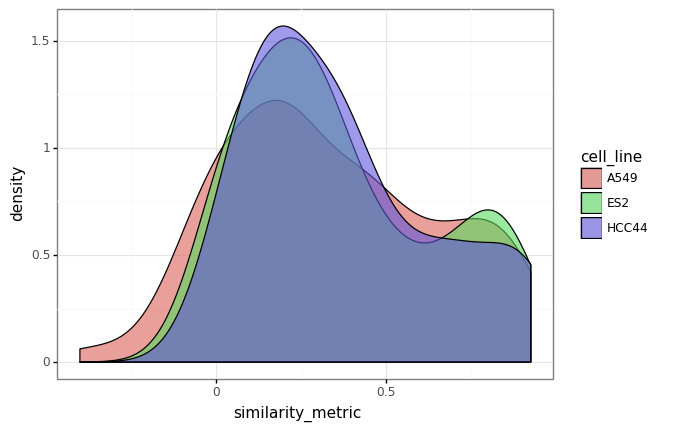

<ggplot: (8790176578443)>

In [7]:
(
    gg.ggplot(pairwise_corr_df, gg.aes(x="similarity_metric"))
    + gg.geom_density(gg.aes(fill="cell_line"), alpha=0.6)
    + gg.theme_bw()
)

### Part 2: Replicate reproducibility

`operation="precision_recall"`

Given a profiling dataframe, cytominer-eval can quickly calculate precision and recall of all replicate perturbations.

To calculate precision recall for every perturbation, we first rank order all perturbations by pairwise correlations.
We use a user-defined `k` as a threshold for calling hits.

### Precision

precision = number of replicates selected in top k ranking / k

### Recall

recall = number of replicates selected in top k ranking / number of total replicates

Here, calculate precision and recall for a range of k.

In [9]:
precision_recall_at_k = []

for cell_line in df.Metadata_cell_line.unique():
    cell_line_df = df.query("Metadata_cell_line == @cell_line")
    
    k_list = [2, 3, 5, 10, 15, 25]
    
    precision_recall_results = evaluate(
        profiles=cell_line_df,
        features=features,
        meta_features=meta_features,
        replicate_groups=["Metadata_gene_name", "Metadata_pert_name"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k=k_list
    ).assign(cell_line=cell_line)

    precision_recall_at_k.append(precision_recall_results)

In [11]:
precision_recall_at_k = pd.concat(precision_recall_at_k).reset_index(drop=True)

print(precision_recall_at_k.shape)
precision_recall_at_k.head()

(2142, 6)


,Metadata_gene_name,Metadata_pert_name,k,precision,recall,cell_line
0,AKT1,AKT1-1,2.0,0.0,0.0,HCC44
1,AKT1,AKT1-2,2.0,0.0,0.0,HCC44
2,ARID1B,ARID1B-1,2.0,0.0,0.0,HCC44
3,ARID1B,ARID1B-2,2.0,0.0,0.0,HCC44
4,ATF4,ATF4-1,2.0,0.0,0.0,HCC44


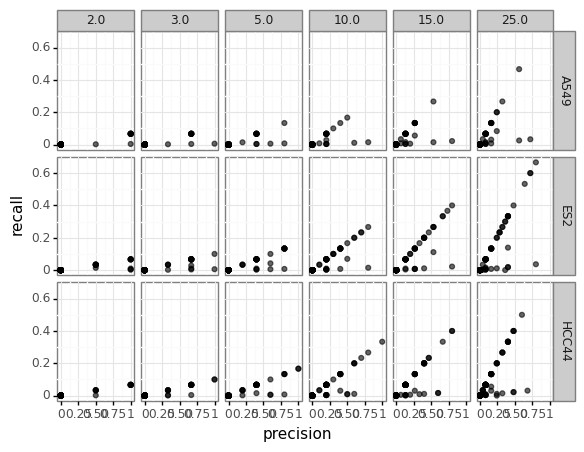

<ggplot: (8790124303948)>

In [12]:
(
    gg.ggplot(precision_recall_at_k, gg.aes(x="precision", y="recall"))
    + gg.geom_point(alpha=0.6)
    + gg.facet_grid("cell_line~k")
    + gg.theme_bw()
)

### Part 3: mp-value

`operation="mp-value"`

Calculate the "multidimensional perturbation value" (mp-value).

> Hutz, J. et al. “The Multidimensional Perturbation Value: A Single Metric to Measure Similarity and Activity of Treatments in High-Throughput Multidimensional Screens” Journal of Biomolecular Screening, Volume: 18 issue: 4, page(s): 367-377. doi: 10.1177/1087057112469257

The mp-value is the mahalanobis distance between a perturbation and control, as compared to a randomly permuted null distribution.

**NOTE: Parts 3 and 4 (mp-value and grit) introduce the concept of _control perturbations_**

In [13]:
# Chr2 is an intergenic CRISPR cutting control
control_perts = df.query("Metadata_gene_name == 'Chr2'").Metadata_pert_name.unique().tolist()
control_perts

['Chr2-1', 'Chr2-4', 'Chr2-5', 'Chr2-2', 'Chr2-3', 'Chr2-6']

In [14]:
mp_values = []

for cell_line in df.Metadata_cell_line.unique():
    cell_line_df = df.query("Metadata_cell_line == @cell_line")
    
    for num_perm in [10, 100, 1000]:
    
        mp_results = evaluate(
            profiles=cell_line_df,
            features=features,
            meta_features=meta_features,
            replicate_groups="Metadata_pert_name",
            operation="mp_value",
            similarity_metric="pearson",
            mp_value_params={"rescale_pca": True, "nb_permutations": num_perm},
            grit_control_perts=control_perts
        ).assign(cell_line=cell_line, permutations=num_perm)
        
        mp_values.append(mp_results)

In [15]:
mp_values = pd.concat(mp_values).reset_index(drop=True)

print(mp_values.shape)
mp_values.head()

(1071, 4)


,Metadata_pert_name,mp_value,cell_line,permutations
0,AKT1-1,0.2,HCC44,10
1,AKT1-2,0.2,HCC44,10
2,ARID1B-1,0.1,HCC44,10
3,ARID1B-2,0.1,HCC44,10
4,ATF4-1,0.0,HCC44,10


/Users/mbornhol/miniconda3/envs/noncyto/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/Users/mbornhol/miniconda3/envs/noncyto/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 444 rows containing non-finite values.


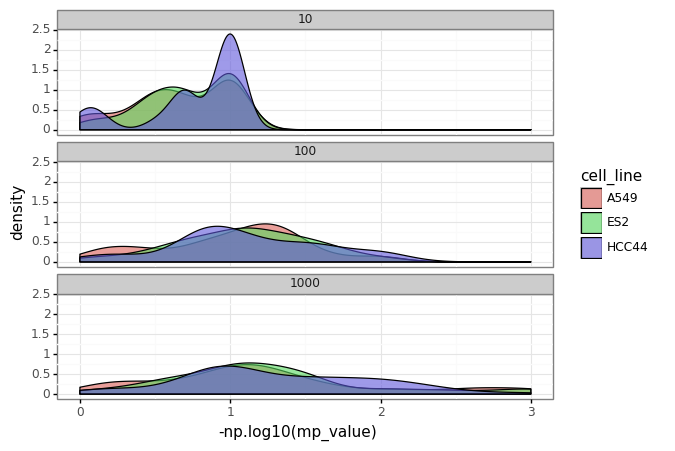

<ggplot: (8790125296104)>

In [16]:
(
    gg.ggplot(mp_values, gg.aes(x="-np.log10(mp_value)"))
    + gg.geom_density(gg.aes(fill="cell_line"), alpha=0.6)
    + gg.facet_wrap("~permutations", nrow=3)
    + gg.theme_bw()
)

### Part 4: Grit

`operation="grit"`

Grit is a metric that represents the strength and reproducibility of a given perturbation.
The strength of the perturbation is measured relative to a reference panel of controls.
The reproducibility of the pertubation is measured relative to perturbation replicates. 

For more details about the metric and to observe its behavior, see https://github.com/broadinstitute/grit-benchmark.

#### The replicate_groups variable

Of all metrics, `grit` requires a slightly more complicated `replicate_groups` variable.

In `grit`, the variable must be a dictionary with two keys: "profile_col" and "replicate_group_col".

- "profile_col" - this column stores profile identifiers.
    - It can include unique entries, but it is not required.
    - `cytominer_eval` will calculate grit for each perturbation in the "profile_col"
- "replicate_group_col" - this column stores replicate and group identifiers.
    - Typically one higher level "above" the profile_col, the replicate_group_col indicates how the profiles should be grouped together
  
In a CRISPR experiment, for example, the "profile_col" stores guide profiles while the "replicate_group_col" stores the guide targets.
If multiple guides target the same gene, `grit` will determine the reproducibility and strength of the guide.

In [17]:
grit_replicate_groups = {
    "profile_col": "Metadata_pert_name",
    "replicate_group_col": "Metadata_gene_name"
}

In [18]:
grit_scores = []

for cell_line in df.Metadata_cell_line.unique():
    cell_line_df = df.query("Metadata_cell_line == @cell_line")
    
    grit_results = evaluate(
        profiles=cell_line_df,
        features=features,
        meta_features=meta_features,
        replicate_groups=grit_replicate_groups,
        operation="grit",
        similarity_metric="pearson",
        grit_replicate_summary_method="median",
        grit_control_perts=control_perts
    ).assign(cell_line=cell_line)

    grit_scores.append(grit_results)

In [19]:
grit_scores = pd.concat(grit_scores).reset_index(drop=True)

print(grit_scores.shape)
grit_scores.head()

(357, 4)


,perturbation,group,grit,cell_line
0,AKT1-1,AKT1,0.918037,HCC44
1,AKT1-2,AKT1,0.858680,HCC44
2,ARID1B-1,ARID1B,0.304972,HCC44
3,ARID1B-2,ARID1B,0.096940,HCC44
4,ATF4-1,ATF4,-0.122386,HCC44


/Users/mbornhol/miniconda3/envs/noncyto/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 18 rows containing non-finite values.


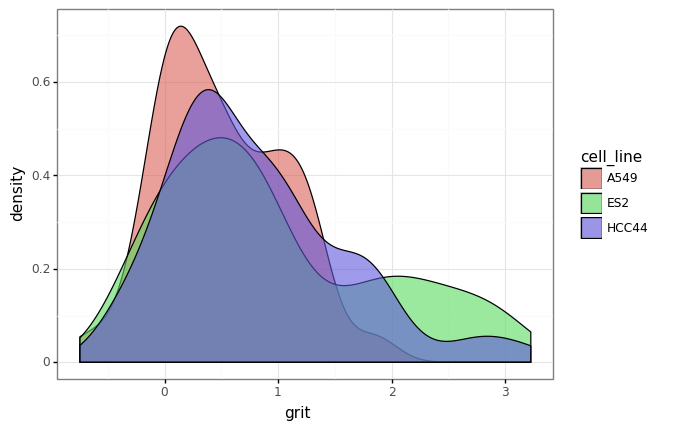

<ggplot: (8790176556358)>

In [20]:
(
    gg.ggplot(grit_scores, gg.aes(x="grit"))
    + gg.geom_density(gg.aes(fill="cell_line"), alpha=0.6)
    + gg.theme_bw()
)

## Part 5: enrichment
Use the enrichment analysis developed by Shantanu and Juan. It looks at the shortest connections within the dataset and evaluates based score is based on the fisher exact odds score
`operation="enichment"`

In [21]:
percent_list = [0.99, 0.98, 0.97, 0.96]

enrichment_result = evaluate(
    profiles=df,
    features=features,
    meta_features=meta_features,
    replicate_groups=["Metadata_gene_name"],
    operation="enrichment",
    similarity_metric="pearson",
    enrichment_percentile= percent_list,
)

In [22]:
enrichment_result[["enrichment_percentile","ods_ratio"]]

,enrichment_percentile,ods_ratio
0,0.99,3.685582
1,0.98,2.597346
2,0.97,2.116626
3,0.96,1.875379


## Combine metrics and generate a combined prioritization rank

In [23]:
merge_cols = ["Metadata_gene_name", "Metadata_pert_name", "cell_line"]

metric_df = (
    pairwise_corr_df.merge(
        precision_recall_at_k.query("k == 25"),
        on=merge_cols
    )
    .merge(
        mp_values.query("permutations == 1000"),
        on=["Metadata_pert_name", "cell_line"]
    )
    .merge(
        grit_scores,
        left_on=merge_cols,
        right_on=["group", "perturbation", "cell_line"],
    )
    .rename(
        {
            "similarity_metric": "median_correlation",
            "k": "precision_recall_k",
            "permutations": "mp_value_permutations"
        },
        axis="columns"
    )
)
    
print(metric_df.shape)
metric_df.head()

(357, 12)


,Metadata_gene_name,Metadata_pert_name,median_correlation,cell_line,precision_recall_k,precision,recall,mp_value,mp_value_permutations,perturbation,group,grit
0,AKT1,AKT1-1,0.240928,HCC44,25.0,0.16,0.133333,0.115,1000,AKT1-1,AKT1,0.918037
1,AKT1,AKT1-2,0.178413,HCC44,25.0,0.08,0.066667,0.161,1000,AKT1-2,AKT1,0.858680
2,ARID1B,ARID1B-1,0.220200,HCC44,25.0,0.00,0.000000,0.094,1000,ARID1B-1,ARID1B,0.304972
3,ARID1B,ARID1B-2,0.133993,HCC44,25.0,0.00,0.000000,0.138,1000,ARID1B-2,ARID1B,0.096940
4,ATF4,ATF4-1,0.797046,HCC44,25.0,0.00,0.000000,0.002,1000,ATF4-1,ATF4,-0.122386


/Users/mbornhol/miniconda3/envs/noncyto/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


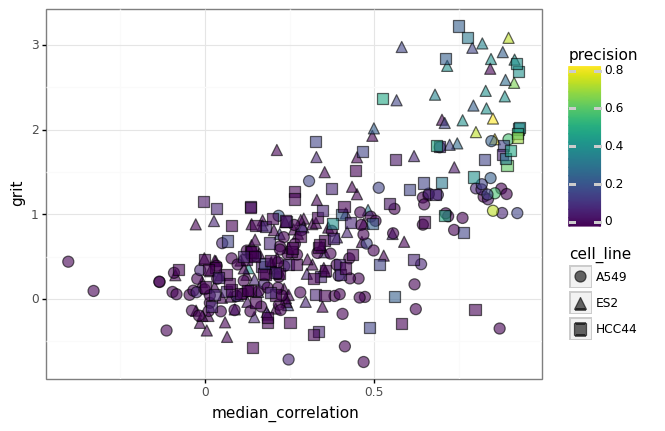

<ggplot: (8790074077323)>

In [24]:
(
    gg.ggplot(metric_df, gg.aes(x="median_correlation", y="grit"))
    + gg.geom_point(gg.aes(fill="precision", shape="cell_line"), size=4, alpha=0.6)
    + gg.theme_bw()
)

/Users/mbornhol/miniconda3/envs/noncyto/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10


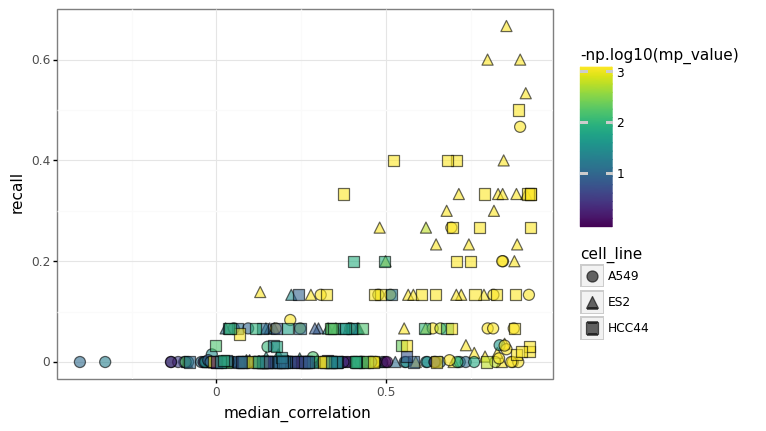

<ggplot: (8790075732505)>

In [25]:
(
    gg.ggplot(metric_df, gg.aes(x="median_correlation", y="recall"))
    + gg.geom_point(gg.aes(fill="-np.log10(mp_value)", shape="cell_line"), size=4, alpha=0.6)
    + gg.theme_bw()
)

In [26]:
min_max_scaler = preprocessing.MinMaxScaler()

metric_summary_df = (
    metric_df
    .assign(
        metric_sum_scaled=(
            min_max_scaler.fit_transform(metric_df.grit.values.reshape(-1, 1)) + 
            min_max_scaler.fit_transform(metric_df.median_correlation.values.reshape(-1, 1)) +
            min_max_scaler.fit_transform(metric_df.precision.values.reshape(-1, 1)) +
            min_max_scaler.fit_transform(metric_df.recall.values.reshape(-1, 1)) -
            min_max_scaler.fit_transform(metric_df.mp_value.values.reshape(-1, 1))
        )
    )
    .sort_values(by="metric_sum_scaled", ascending=False)
    .reset_index(drop=True)
    .dropna()
)

metric_summary_df.head(10)

,Metadata_gene_name,Metadata_pert_name,median_correlation,cell_line,precision_recall_k,precision,recall,mp_value,mp_value_permutations,perturbation,group,grit,metric_sum_scaled
0,MYC,MYC-1,0.896095,ES2,25.0,0.72,0.600000,0.0,1000,MYC-1,MYC,3.087105,3.741246
1,YAP1,YAP1-2,0.855538,ES2,25.0,0.80,0.666667,0.0,1000,YAP1-2,YAP1,1.888577,3.609051
2,CCND1,CCND1-2,0.912482,ES2,25.0,0.64,0.533333,0.0,1000,CCND1-2,CCND1,2.555242,3.419675
3,EGLN1,EGLN1-9,0.799812,ES2,25.0,0.72,0.600000,0.0,1000,EGLN1-9,EGLN1,1.972640,3.388326
4,CDK2,CDK2-2,0.891436,HCC44,25.0,0.60,0.500000,0.0,1000,CDK2-2,CDK2,1.582908,3.059086
5,ITGAV,ITGAV-2,0.895882,A549,25.0,0.56,0.466667,0.0,1000,ITGAV-2,ITGAV,1.886879,3.038947
6,CDK4,CDK4-2,0.913841,ES2,25.0,0.40,0.333333,0.0,1000,CDK4-2,CDK4,2.829412,2.889714
7,ITGAV,ITGAV-2,0.919061,HCC44,25.0,0.40,0.333333,0.0,1000,ITGAV-2,ITGAV,2.783719,2.882135
8,ITGAV,ITGAV-1,0.925652,HCC44,25.0,0.40,0.333333,0.0,1000,ITGAV-1,ITGAV,2.689741,2.863432
9,GPX4,GPX4-1,0.844319,ES2,25.0,0.40,0.333333,0.0,1000,GPX4-1,GPX4,2.836964,2.839359


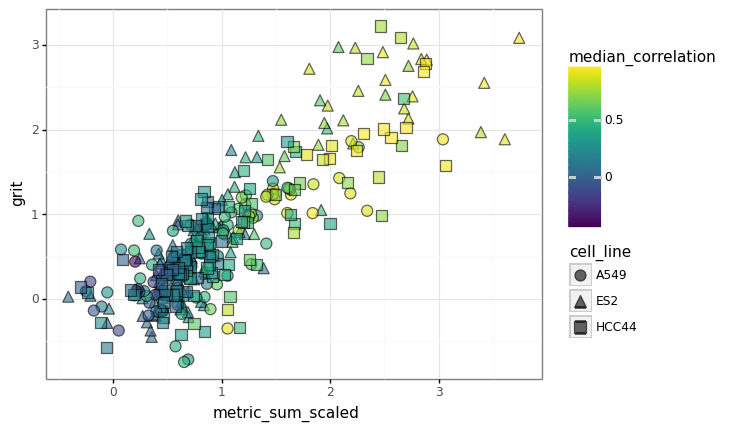

<ggplot: (8790073997343)>

In [27]:
(
    gg.ggplot(metric_summary_df, gg.aes(x="metric_sum_scaled", y="grit"))
    + gg.geom_point(gg.aes(fill="median_correlation", shape="cell_line"), size=4, alpha=0.6)
    + gg.theme_bw()
)

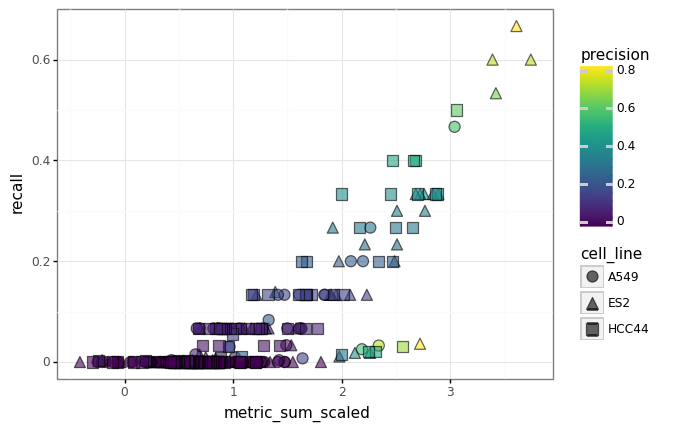

<ggplot: (8790074061942)>

In [28]:
(
    gg.ggplot(metric_summary_df, gg.aes(x="metric_sum_scaled", y="recall"))
    + gg.geom_point(gg.aes(fill="precision", shape="cell_line"), size=4, alpha=0.6)
    + gg.theme_bw()
)